In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

#from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz
from tqdm import tqdm

In [101]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig('confusion.png')
    plt.show()

In [102]:
df = pd.read_csv('../input/PS_20174392719_1491204439457_log.csv')
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})

In [103]:
df.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [104]:
df.loc[df.isFraud == 1].type.drop_duplicates().values

array(['TRANSFER', 'CASH_OUT'], dtype=object)

In [105]:
# BORRA TODOS LOS DATOS QUE NO SON TRANSFER Y CASH_OUT ???

# df = df[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]

In [106]:
len(df)

6362620

In [107]:
df.loc[(df.isFraud == 1) & (df.type == 'TRANSFER')].amount.median()

445705.76

In [108]:
df.loc[(df.isFraud == 0) & (df.type == 'TRANSFER')].amount.median()

486521.91000000003

### 1) Aproximación HEURISTICA

Un humano plantea que todo lo superió a 200k es fraudulento

In [109]:
df['Fraud_Heuristic'] = np.where(((df['type'] == 'TRANSFER') & 
                                  (df['amount'] > 200000)),1,0)

In [110]:
df['Fraud_Heuristic'].sum()

409110

In [111]:
from sklearn.metrics import f1_score

### ERRORES

Los errores de tipo 1 y 2 pueden resultar confusos porque hay varias formas de representarlos, según el contexto y el campo de aplicación. A continuación se muestran algunas representaciones y analogías comunes:
#### Tipo I (α o alfa): Falso positivo
#### Tipo II (β o beta): Falso Negativo :

*Analogía jurídica:*

- Error Tipo I: Condenar a una persona inocente (Falso Positivo).

- Error Tipo II: Absolución de un culpable (Falso Negativo).

*Toma de decisiones:*

- Error Tipo I: Actuar cuando no deberías haberlo hecho (Falso Positivo).

- Error tipo II: No actuar cuando debería (Falso Negativo).

*Analogía de la alarma de incendio:*

- Error tipo I: La alarma contra incendios suena, pero no hay incendio (Falsa alarma).

- Error tipo II: hay un incendio, pero la alarma contra incendios no suena (detección perdida).


*Precisión y recuperación*

- Precisión = TP / (TP + FP)

- Recall (recuperación) = TP / (TP + FN)

#### Puntuación F1  --> 1= OPTIMO

F1 = 2* Precisión * Recuperación / (precisión + recuperación)

La puntuación F1 es la media armónica de precisión y recuperación, lo que la hace sensible a valores pequeños. Esto significa que si la precisión o la recuperación son significativamente más bajas que la otra, tendrá un impacto más pronunciado en la puntuación F1.

** La puntuación F1 varía de 0 a 1, donde una puntuación de 1 indica precisión y recuperación perfectas y 0 indica un rendimiento deficiente. Una puntuación F1 alta significa que el modelo tiene alta precisión y alta recuperación, lo que indica que es un buen modelo para la tarea de clasificación binaria. ** 



https://medium.com/@maxgrossman10/accuracy-recall-precision-f1-score-with-python-4f2ee97e0d6


In [112]:
f1_score(y_pred=df['Fraud_Heuristic'],y_true=df['isFraud'])

0.013131315551742894

In [113]:
from sklearn.metrics import confusion_matrix

In [114]:
cm = confusion_matrix(y_pred=df['Fraud_Heuristic'],y_true=df['isFraud'])

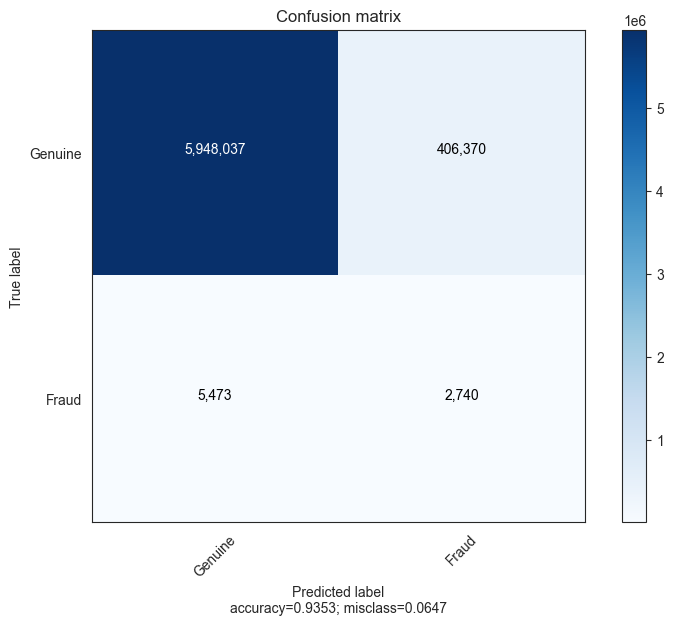

In [115]:
plot_confusion_matrix(cm,['Genuine','Fraud'], normalize=False)

In [116]:
df.shape

(6362620, 12)

### 1) Aproximación FEATURES  (Se generan enfoque mnanuales para que luego lo procese un alagoritmo de ML)

- La intiución dice que  "El fraude no descansa" , por lo que en horariao nocturno sería mas visible esta proporción de fraudes, y aumenta en forma relativa


In [117]:
df['hour'] = df['step'] % 24

In [118]:
frauds = []
genuine = []
for i in range(24):
    f = len(df[(df['hour'] == i) & (df['isFraud'] == 1)])
    g = len(df[(df['hour'] == i) & (df['isFraud'] == 0)])
    frauds.append(f)
    genuine.append(g)

In [119]:
df.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud,Fraud_Heuristic,hour
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0,1
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0,1
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,0,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,0,1


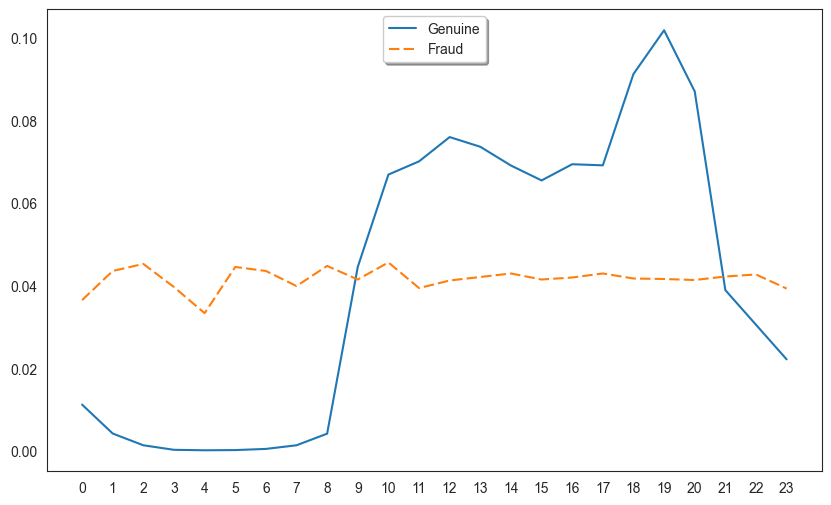

In [120]:
sns.set_style("white")

fig, ax = plt.subplots(figsize=(10,6))
gen = ax.plot(genuine/np.sum(genuine), label='Genuine')
fr = ax.plot(frauds/np.sum(frauds),dashes=[5, 2], label='Fraud')
#frgen = ax.plot(np.devide(frauds,genuine),dashes=[1, 1], label='Fraud vs Genuine')
plt.xticks(np.arange(24))
legend = ax.legend(loc='upper center', shadow=True)
fig.savefig('time.png')

 #### Visualizar y Validad Porcentaje de Fraudes por Hora

 * A las 5AM casi el 60% de las transacciones son fraudulentas

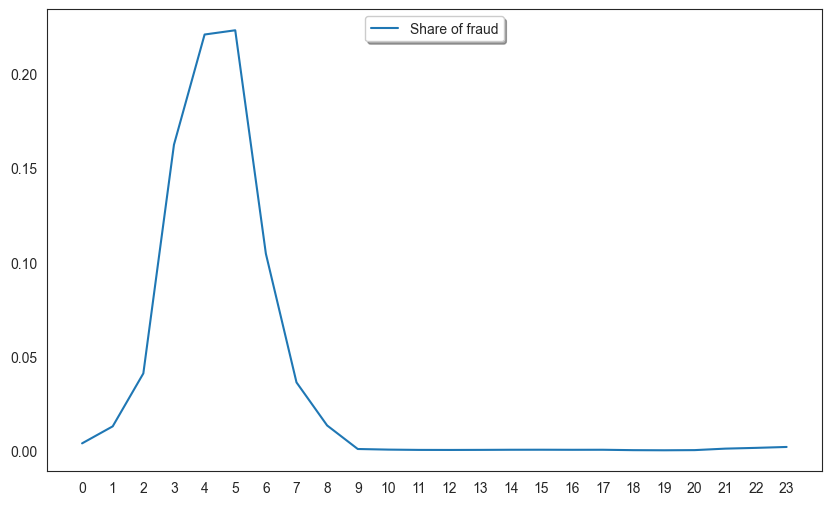

In [121]:
sns.set_style("white")

fig, ax = plt.subplots(figsize=(10,6))
#gen = ax.plot(genuine/np.sum(genuine), label='Genuine')
#fr = ax.plot(frauds/np.sum(frauds),dashes=[5, 2], label='Fraud')
frgen = ax.plot(np.divide(frauds,np.add(genuine,frauds)), label='Share of fraud')
plt.xticks(np.arange(24))
legend = ax.legend(loc='upper center', shadow=True)
fig.savefig('time_comp.png')

In [122]:
dfFraudTransfer = df[(df.isFraud == 1) & (df.type == 'TRANSFER')]


# Transnfieren dinero a una cuenta que los estafadores controlan

In [123]:
dfFraudCashOut = df[(df.isFraud == 1) & (df.type == 'CASH_OUT')]

In [124]:
dfFraudTransfer.nameDest.isin(dfFraudCashOut.nameOrig).any()

False

In [125]:
dfNotFraud = df[(df.isFraud == 0)]

In [126]:
dfFraud = df[(df.isFraud == 1)]

In [127]:
dfFraudTransfer.loc[dfFraudTransfer.nameDest.isin(
    dfNotFraud.loc[dfNotFraud.type == 'CASH_OUT'].nameOrig.drop_duplicates())]

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud,Fraud_Heuristic,hour
1030443,65,TRANSFER,1282971.57,C1175896731,1282971.57,0.0,C1714931087,0.0,0.0,1,0,1,17
6039814,486,TRANSFER,214793.32,C2140495649,214793.32,0.0,C423543548,0.0,0.0,1,0,1,6
6362556,738,TRANSFER,814689.88,C2029041842,814689.88,0.0,C1023330867,0.0,0.0,1,0,1,18


In [128]:
len(dfFraud[(dfFraud.oldBalanceDest == 0) & (dfFraud.newBalanceDest == 0) & (dfFraud.amount)]) / (1.0 * len(dfFraud))

0.4955558261293072

In [129]:
len(dfNotFraud[(dfNotFraud.oldBalanceDest == 0) & (dfNotFraud.newBalanceDest == 0) & (dfNotFraud.amount)]) / (1.0 * len(dfNotFraud))

0.36403176567065976

In [130]:
dfOdd = df[(df.oldBalanceDest == 0) & 
           (df.newBalanceDest == 0) & 
           (df.amount)]

In [131]:
len(dfOdd[(dfOdd.isFraud == 1)]) / len(dfOdd)

0.0017563725684812685

#### Insigth

Muchas de las transacciones fraudulentas tenían su balance anterior de las cuentas de destino en 0 y un monto del movimiento distinto de 0.   (transfieren dinero a una cuenta sin saldo, SOSPECHOSO)

In [132]:
len(dfOdd[(dfOdd.oldBalanceOrig <= dfOdd.amount)]) / len(dfOdd)

0.5339372608183056

pero consideranto el total de las transaccione esto ocurre frecuentemente. NO se sabe si hay otro sistema de prevención de fraude en paralelo, por lo que no puede tomarse como un indicador confiable.

In [133]:
len(dfOdd[(dfOdd.oldBalanceOrig <= dfOdd.amount) & (dfOdd.isFraud == 1)]) / len(dfOdd[(dfOdd.isFraud == 1)])

0.9636363636363636

In [134]:
dfOdd.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldBalanceOrig',
       'newBalanceOrig', 'nameDest', 'oldBalanceDest', 'newBalanceDest',
       'isFraud', 'isFlaggedFraud', 'Fraud_Heuristic', 'hour'],
      dtype='object')

In [135]:
dfOdd.head(20)

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud,Fraud_Heuristic,hour
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.0,0,0,0,1
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.0,0,0,0,1
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.0,1,0,0,1
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.0,0,0,0,1
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.0,0,0,0,1
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.0,0,0,0,1
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.0,0,0,0,1
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.0,0,0,0,1
11,1,PAYMENT,3099.97,C249177573,20771.00,17671.03,M2096539129,0.0,0.0,0,0,0,1
12,1,PAYMENT,2560.74,C1648232591,5070.00,2509.26,M972865270,0.0,0.0,0,0,0,1


In [136]:
df.head(20)

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud,Fraud_Heuristic,hour
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0,0,1
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0,0,1
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0,0,1
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0,0,1
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0,0,1
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0,0,1
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0,0,1
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0,0,1
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0,0,1
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0,0,1


### 2) Preparar el modelo para KERAS

- Deben hacerce varias adecuaciones para el modelo.
- Información NOMINAL debe transformarse en NUMERICA separada en categorías.  (ONE-HOT ENCODING)
- Información ORDINAL es también categórica pero sería suceptible de priorizarse u ordenarse.
- Informació NUMERICA lista para ser procesada.



In [137]:
df['type'] = 'type_' + df['type'].astype(str)


# Genero 2 nuevas columnas Type_TRANSFER y Typa_CASH_OUT
# Asignando 1 o 0 si corresponde.

In [138]:
# Get dummies
dummies = pd.get_dummies(df['type'])

# Add dummies to df
df = pd.concat([df,dummies],axis=1)

#remove original column
# del df['type']

In [139]:
map_dict = {}
for token, value in enumerate(df['type'].unique()):
    map_dict[value] = token
    

map_dict

{'type_PAYMENT': 0,
 'type_TRANSFER': 1,
 'type_CASH_OUT': 2,
 'type_DEBIT': 3,
 'type_CASH_IN': 4}

In [140]:
# TOKENIZAR los TIPOS DE MOVIMIENTOS

df['type'].replace(map_dict, inplace = True)

C:\Users\eduar\AppData\Local\Temp\ipykernel_14500\3223436016.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['type'].replace(map_dict, inplace = True)
C:\Users\eduar\AppData\Local\Temp\ipykernel_14500\3223436016.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['type'].replace(map_dict, 

Predictive modeling with Keras

In [142]:
df = df.drop(['nameOrig','nameDest','Fraud_Heuristic'], axis= 1)

In [143]:
df['isNight'] = np.where((2 <= df['hour']) & (df['hour'] <= 6), 1,0)

In [144]:
df[df['isNight'] == 1].isFraud.mean()

0.09788191839325908

In [145]:
df.head()

,step,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud,hour,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,isNight
0,1,0,9839.64,170136.0,160296.36,0.0,0.0,0,0,1,False,False,False,True,False,0
1,1,0,1864.28,21249.0,19384.72,0.0,0.0,0,0,1,False,False,False,True,False,0
2,1,1,181.00,181.0,0.00,0.0,0.0,1,0,1,False,False,False,False,True,0
3,1,2,181.00,181.0,0.00,21182.0,0.0,1,0,1,False,True,False,False,False,0
4,1,0,11668.14,41554.0,29885.86,0.0,0.0,0,0,1,False,False,False,True,False,0


In [146]:
df = df.drop(['step','hour'],axis=1)

In [147]:
df.head()

,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,isNight
0,0,9839.64,170136.0,160296.36,0.0,0.0,0,0,False,False,False,True,False,0
1,0,1864.28,21249.0,19384.72,0.0,0.0,0,0,False,False,False,True,False,0
2,1,181.00,181.0,0.00,0.0,0.0,1,0,False,False,False,False,True,0
3,2,181.00,181.0,0.00,21182.0,0.0,1,0,False,True,False,False,False,0
4,0,11668.14,41554.0,29885.86,0.0,0.0,0,0,False,False,False,True,False,0


In [148]:
df.columns.values

array(['type', 'amount', 'oldBalanceOrig', 'newBalanceOrig',
       'oldBalanceDest', 'newBalanceDest', 'isFraud', 'isFlaggedFraud',
       'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT',
       'type_TRANSFER', 'isNight'], dtype=object)

In [149]:
y_df = df['isFraud']
x_df = df.drop('isFraud',axis=1)

In [150]:
y = y_df.values
X = x_df.values

In [151]:
y.shape

(6362620,)

In [152]:
X.shape

(6362620, 13)

In [153]:
from sklearn.model_selection import train_test_split

In [154]:
# DIVIDIR el sert de datos para realizar el entrenamiento 

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.33, 
                                                    random_state=42)

In [155]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                    test_size=0.1, 
                                                    random_state=42)

In [156]:
from imblearn.over_sampling import SMOTE, RandomOverSampler

In [157]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [158]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD

In [165]:
# Log reg
model = Sequential()
model.add(Dense(1, input_dim=13))
model.add(Activation('sigmoid'))

In [166]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1)                 14        
                                                                 
 activation_1 (Activation)   (None, 1)                 0         
                                                                 
Total params: 14 (56.00 Byte)
Trainable params: 14 (56.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [167]:
model.compile(loss='binary_crossentropy',
              optimizer=SGD(learning_rate=1e-5), 
              metrics=['acc'])

In [168]:
# VER que hay en los datos
print ("\n  X_train_res: ")
print('#### Shape of input numpy array #####')
print(X_train_res.shape)
print('#### Shape of each element in the array #####')
print(X_train_res[0].shape)
print('#### Object type for input data #####')
print(type(X_train_res))
print('##### Object type for first element of input data ####')
print(type(X_train_res[0]))

# VER que hay en los datos
print ("\n  y_train_res: ")
print('#### Shape of input numpy array #####')
print(y_train_res.shape)
print('#### Shape of each element in the array #####')
print(y_train_res[0].shape)
print('#### Object type for input data #####')
print(type(y_train_res))
print('##### Object type for first element of input data ####')
print(type(y_train_res[0]))


# VER que hay en los datos
print ("\n  X_val: ")
print('#### Shape of input numpy array #####')
print(X_val.shape)
print('#### Shape of each element in the array #####')
print(X_val[0].shape)
print('#### Object type for input data #####')
print(type(X_val))
print('##### Object type for first element of input data ####')
print(type(X_val[0]))
# VER que hay en los datos
print ("\n  y_val: ")
print('#### Shape of input numpy array #####')
print(y_val.shape)
print('#### Shape of each element in the array #####')
print(y_val[0].shape)
print('#### Object type for input data #####')
print(type(y_val))
print('##### Object type for first element of input data ####')
print(type(y_val[0]))


  X_train_res: 
#### Shape of input numpy array #####
(7663296, 13)
#### Shape of each element in the array #####
(13,)
#### Object type for input data #####
<class 'numpy.ndarray'>
##### Object type for first element of input data ####
<class 'numpy.ndarray'>

  y_train_res: 
#### Shape of input numpy array #####
(7663296,)
#### Shape of each element in the array #####
()
#### Object type for input data #####
<class 'numpy.ndarray'>
##### Object type for first element of input data ####
<class 'numpy.int64'>

  X_val: 
#### Shape of input numpy array #####
(426296, 13)
#### Shape of each element in the array #####
(13,)
#### Object type for input data #####
<class 'numpy.ndarray'>
##### Object type for first element of input data ####
<class 'numpy.ndarray'>

  y_val: 
#### Shape of input numpy array #####
(426296,)
#### Shape of each element in the array #####
()
#### Object type for input data #####
<class 'numpy.ndarray'>
##### Object type for first element of input data ####
<cla

In [169]:
# PARCHE

# X_train_res = np.array([np.array(val) for val in X_train_res])
#X_val = np.array([np.array(val) for val in X_val])

print(type(X_val)[9])
X_train.view()

numpy.ndarray[9]


array([[4, 209001.09, 7698879.59, ..., False, False, 0],
       [4, 214243.7, 12804312.37, ..., False, False, 0],
       [2, 89493.39, 0.0, ..., False, False, 0],
       ...,
       [0, 13875.37, 16246.26, ..., True, False, 0],
       [2, 114777.7, 11125.0, ..., False, False, 0],
       [2, 220867.1, 58975.07, ..., False, False, 0]], dtype=object)

In [176]:
# PARCHE 
X_train_res=np.asarray(X_train_res).astype(float)

y_train_res=np.asarray(y_train_res).astype(float)

In [177]:
model.fit(X_train_res,y_train_res,
          epochs=5, 
          batch_size=256, 
          validation_data=(X_val,y_val))

Epoch 1/5
29896/29935 [============================>.] - ETA: 0s - loss: 420695.0000 - acc: 0.8906

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

In [125]:
anterior = 12993
fallo = 12994
posterior = 12995

print("FALLO")
print(type(X_train_res[fallo]))
print(type(y_train_res[fallo]))
print("Datos")
print((X_train_res[fallo]))
print((y_train_res[fallo]))

print("ANTERIOR")
print(type(X_train_res[anterior]))
print(type(y_train_res[anterior]))
print("Datos")
print((X_train_res[anterior]))
print((y_train_res[anterior]))

print("POSTERIOR")
print(type(X_train_res[posterior]))
print(type(y_train_res[posterior]))
print("Datos")
print((X_train_res[posterior]))
print((y_train_res[posterior]))



FALLO
<class 'numpy.ndarray'>
<class 'numpy.int64'>
Datos
[2.42825580e+05 0.00000000e+00 0.00000000e+00 1.16782559e+06
 1.49878185e+06 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00]
0
ANTERIOR
<class 'numpy.ndarray'>
<class 'numpy.int64'>
Datos
[2.3815348e+05 1.2182400e+05 0.0000000e+00 3.9216920e+05 6.3032267e+05
 0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00]
0
POSTERIOR
<class 'numpy.ndarray'>
<class 'numpy.int64'>
Datos
[2.0590360e+05 0.0000000e+00 0.0000000e+00 5.1926798e+05 8.3704404e+05
 0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00]
0


In [ ]:
y_pred = model.predict(X_test)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

In [ ]:
y_pred[y_pred > 0.5] = 1
y_pred[y_pred < 0.5] = 0

NameError: name 'y_pred' is not defined

In [ ]:
f1_score(y_pred=y_pred,y_true=y_test)

0.054384286716408395

In [ ]:
cm = confusion_matrix(y_pred=y_pred,y_true=y_test)

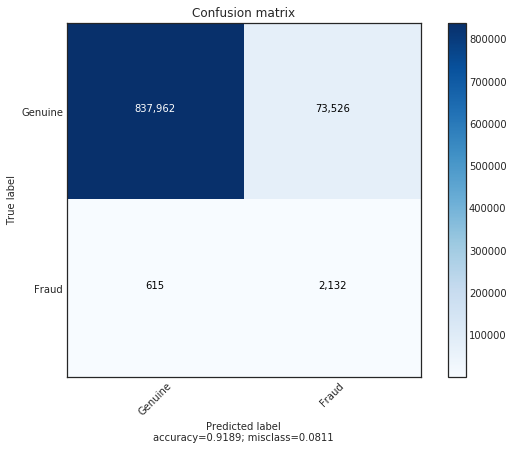

In [ ]:
plot_confusion_matrix(cm,['Genuine','Fraud'], normalize=False)

In [ ]:
model = Sequential()
model.add(Dense(16,input_dim=9))
model.add(Activation('tanh'))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy',optimizer=SGD(lr=1e-4), metrics=['acc'])

In [ ]:
model.fit(X_train_res,y_train_res,
          epochs=5, batch_size=256, 
          validation_data=(X_val,y_val))

Train on 3331258 samples, validate on 185618 samples
Epoch 1/5
3331258/3331258 [==============================] - 22s 7us/step - loss: 0.6064 - acc: 0.6922 - val_loss: 1.0665 - val_acc: 0.1872
Epoch 2/5
 729856/3331258 [=====>........................] - ETA: 17s - loss: 0.6029 - acc: 0.6968

KeyboardInterrupt: 

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred[y_pred > 0.5] = 1
y_pred[y_pred < 0.5] = 0

In [ ]:
f1_score(y_pred=y_pred,y_true=y_test)

0.001674751441885722

In [ ]:
cm = confusion_matrix(y_pred=y_pred,y_true=y_test)

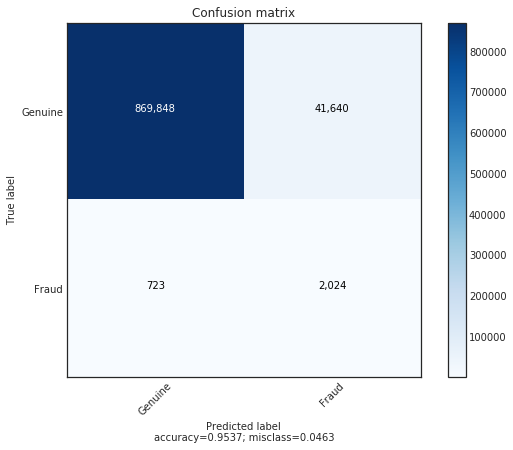

In [ ]:
plot_confusion_matrix(cm,['Genuine','Fraud'], normalize=False)

# Tree based methods

In [ ]:
from sklearn.tree import export_graphviz

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtree=DecisionTreeClassifier()
dtree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

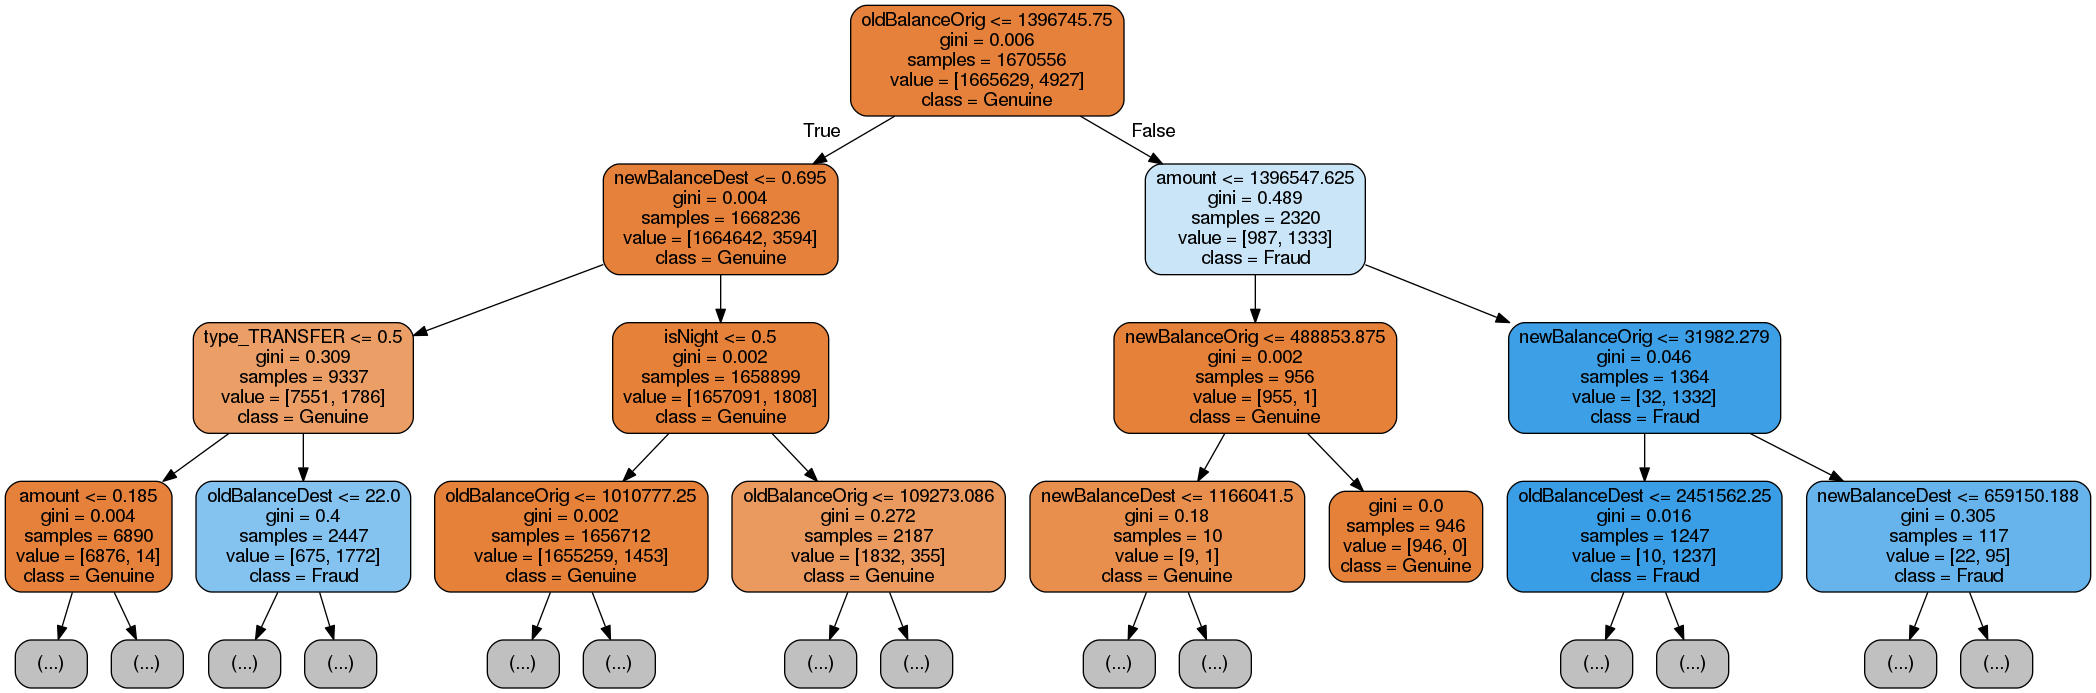

In [ ]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
from IPython.display import Image as PImage

#import pydotplus
dot_data = StringIO()
'''export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)'''
with open("tree1.dot", 'w') as f:
     f = export_graphviz(dtree,
                              out_file=f,
                              max_depth = 3,
                              impurity = True,
                              feature_names = list(df.drop(['isFraud'], axis=1)),
                              class_names = ['Genuine', 'Fraud'],
                              rounded = True,
                              filled= True )
        
#Convert .dot to .png to allow display in web notebook
check_call(['dot','-Tpng','tree1.dot','-o','tree1.png'])

# Annotating chart with PIL
img = Image.open("tree1.png")
draw = ImageDraw.Draw(img)
font = ImageFont.truetype('/usr/share/fonts/truetype/liberation/LiberationSerif-Bold.ttf', 26)
img.save('sample-out.png')
PImage("sample-out.png")


In [ ]:
from sklearn.ensemble import  RandomForestClassifier

In [ ]:
rf = RandomForestClassifier(n_estimators=10,n_jobs=-1)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [ ]:
y_pred = rf.predict(X_test)

In [ ]:
f1_score(y_pred=y_pred,y_true=y_test)

0.8749502190362406

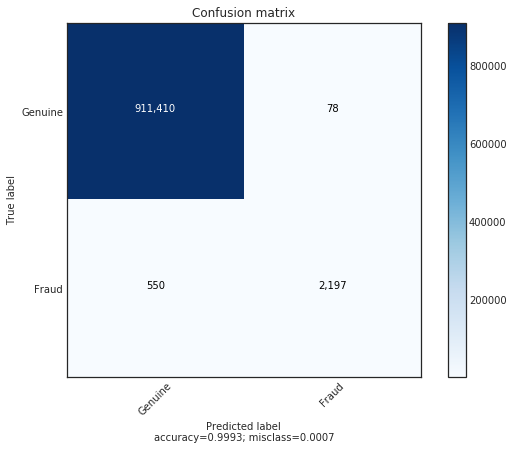

In [ ]:
cm = confusion_matrix(y_pred=y_pred,y_true=y_test)
plot_confusion_matrix(cm,['Genuine','Fraud'], normalize=False)

In [ ]:
import xgboost as xgb

In [ ]:
booster = xgb.XGBClassifier(n_jobs=-1)
booster = booster.fit(X_train,y_train)

In [ ]:
y_pred = booster.predict(X_test)

In [ ]:
f1_score(y_pred=y_pred,y_true=y_test)

0.85572959604286891

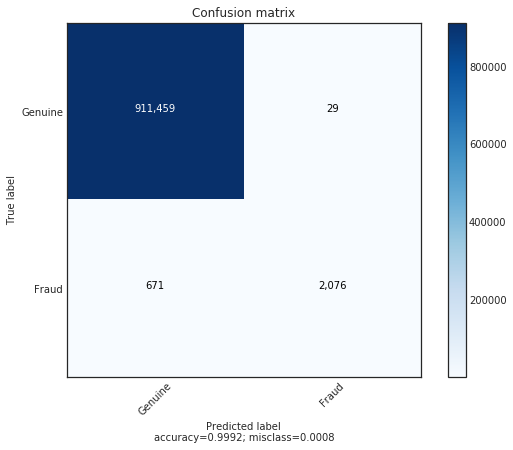

In [ ]:
cm = confusion_matrix(y_pred=y_pred,y_true=y_test)
plot_confusion_matrix(cm,['Genuine','Fraud'], normalize=False)

# Entity embeddings

In [ ]:
# Reload data
df = pd.read_csv('../input/PS_20174392719_1491204439457_log.csv')
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})

In [ ]:
df.head()

In [ ]:
df = df.drop(['nameDest','nameOrig','step'],axis=1)

In [ ]:
df['type'].unique()

In [ ]:
map_dict = {}
for token, value in enumerate(df['type'].unique()):
    map_dict[value] = token   

In [ ]:
map_dict

In [ ]:
df["type"].replace(map_dict, inplace=True)

In [ ]:
df.head()

In [ ]:
other_cols = [c for c in df.columns if ((c != 'type') and (c != 'isFraud'))]

In [ ]:
other_cols

In [ ]:
from keras.models import Model
from keras.layers import Embedding, Merge, Dense, Activation, Reshape, Input, Concatenate

In [ ]:
num_types = len(df['type'].unique())
type_embedding_dim = 3

In [ ]:
inputs = []
outputs = []

In [ ]:
type_in = Input(shape=(1,))
type_embedding = Embedding(num_types,type_embedding_dim,input_length=1)(type_in)
type_out = Reshape(target_shape=(type_embedding_dim,))(type_embedding)

type_model = Model(type_in,type_out)

inputs.append(type_in)
outputs.append(type_out)

In [ ]:
num_rest = len(other_cols)

In [ ]:
rest_in = Input(shape = (num_rest,))
rest_out = Dense(16)(rest_in)

rest_model = Model(rest_in,rest_out)

inputs.append(rest_in)
outputs.append(rest_out)

In [ ]:
concatenated = Concatenate()(outputs)

In [ ]:
x = Dense(16)(concatenated)
x = Activation('sigmoid')(x)
x = Dense(1)(concatenated)
model_out = Activation('sigmoid')(x)

In [ ]:
merged_model = Model(inputs, model_out)
merged_model.compile(loss='binary_crossentropy', 
                     optimizer='adam', 
                     metrics=['accuracy'])

In [ ]:
types = df['type']

In [ ]:
rest = df[other_cols]

In [ ]:
target = df['isFraud']

In [ ]:
history = merged_model.fit([types.values,rest.values],target.values, 
                           epochs = 1, batch_size = 128)

In [ ]:
merged_model.summary()